#

# <font style="color:blue">Project 1 - Part 1: Data Understanding & Pipeline Check</font>

Here, we will slightly modify the steps  we had used to train Neural Networks:


- Step 1 - Understand your problem
- Step 2A - Get the data
- Step 2B - Explore & Understand your data
- Step 2C - Create a sample data from the dataset
- Step 3 - Data Preparation
- Step 4 - Train a simple model on sample data, and check the pipeline before training the full network
- Step 5 - Train on full Data
- Step 6 - Improve your model


In this notebook we will detail the steps 1 to 4, and do some coding along the way! You will implement Steps 5 & 6 in the next notebook.

This notebook contains  30 points. <font style="color:red">The sections in red are the ones that carry marks.</font>

# <font style="color:blue">Step 1: Understand Your Problem </font><a name="step1"></a>

As you already know, Image Classification helps classify an image based on its visual content. So, the model is supposed to look at the given image and predict which object is present in it. Obviously, the number of objects which it can predict depends on how many you trained it on.


In our problem, we want to classify an input image between **3 animals - Cat, Dog and Panda**. 

### <font style="color:green">What Do We Need and How to Achieve It? </font>

You need correctly-labelled images of each animal. Train a decent-sized network to , understand the input image.

# <font style="color:blue">Step 2A: Get the Data </font><a name="step2a"></a>

Let’s use a dataset from kaggle. [**Check it out here**](https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda).

It has separate folders for each animal, each consisting of `1000` images. We have split it into `80:20` ratio for `train:validation`. To download, [**click  here**](https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1).

In [ ]:
!wget "https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1" -O data.zip

### <font style="color:green">Extract the Data</font>

In [ ]:
!unzip -q data.zip

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# <font style="color:blue">Step 2B: Explore the Data</font><a name="step2b"></a>

Here are  some examples:

### <font style="color:green">Folder Structure </font>

In [2]:
!tree -d ./cat-dog-panda

/bin/bash: tree: command not found


### <font style="color:green">Import the Datasets Module</font>

Load the data,  using the datasets module, and . , check out its structure .

In [3]:
from torchvision import datasets

### <font style="color:green">Create a Dataset Object </font>

In [4]:
train_data = datasets.ImageFolder("./cat-dog-panda/training")
validation_data = datasets.ImageFolder("./cat-dog-panda/validation")

### <font style="color:green">List the Classes</font>

It simply prints the sub folders present under the training or validation folder.

In [5]:
print(train_data.classes)
print(validation_data.classes)

['cat', 'dog', 'panda']
['cat', 'dog', 'panda']


### <font style="color:green">Get the Class ID to Name Mapping</font>

In [6]:
print(train_data.class_to_idx)
print(validation_data.class_to_idx)

{'cat': 0, 'dog': 1, 'panda': 2}
{'cat': 0, 'dog': 1, 'panda': 2}


### <font style="color:red">Find the Number of Samples in Training and Validation Folders</font> 

In [7]:
print(len(train_data))
print(len(validation_data))

2400
600


### <font style="color:red">Display Some Samples</font>
Display one sample from each class. We know that the train dataset contains 

- cats from 0 to 799
- dogs from 800 to 1599
- pandas from 1600 to 2399

Take one sample from each class and display using matplotlib

In [8]:
# Enter Code Here
def show_img(image_ind):
    img, target = train_data[image_ind]
    print('image size: {}, target: {}'.format(img.size, target))
    
    plt.imshow(img)
    plt.show()

image size: (500, 374), target: 0


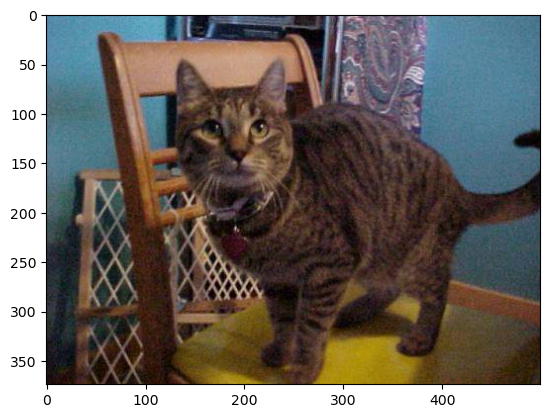

In [9]:
# Enter Code Here
show_img(0)

image size: (382, 478), target: 1


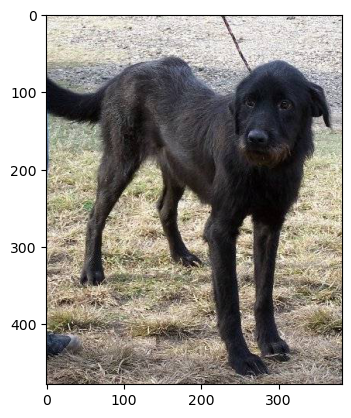

In [10]:
show_img(800)

image size: (480, 500), target: 2


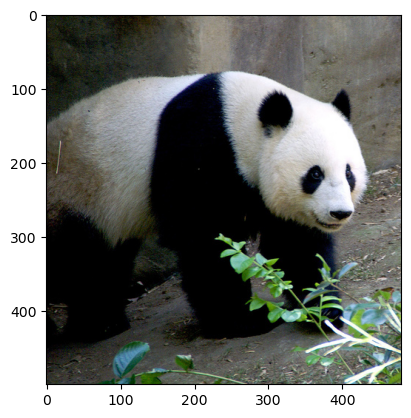

In [11]:
show_img(1600)

**Note:** The images are all of different size.

# <font style="color:blue">Step 2C: Create Sample Data</font><a name="step2c"></a>

Take `5%` images from training and validation to create a small sample dataset, which will check our training pipeline.

In [12]:
import torch
import numpy as np

In [13]:
subset_size = .05

### <font style="color:green">Create a Subset From the Original Data</font>

Instead of copying the original data, use the `Subset` method in `Torch` to create a subset of the data. And use this to train the model.


This is new. Let’ss see how it is done.

In [14]:
train_subset = torch.utils.data.Subset(train_data,np.arange(0,len(train_data),1./subset_size))
validation_subset = torch.utils.data.Subset(validation_data,np.arange(0,len(validation_data),1./subset_size))

In [15]:
train_subset_loader = torch.utils.data.DataLoader(train_subset,
                                         batch_size=8,
                                         num_workers=1,
                                         shuffle=False)
validation_subset_loader = torch.utils.data.DataLoader(validation_subset, 
                                         batch_size=8,
                                         num_workers=1,
                                         shuffle=False)

In [16]:
print("Train Subset Size: {}".format(len(train_subset_loader.dataset)))
print("Validation Subset Size: {}".format(len(validation_subset_loader.dataset)))

Train Subset Size: 120
Validation Subset Size: 30


You can see that the subset data is only 5% of the original training and validation data.

We will create a separate function called `subset_data_loader` to create data loaders for subsets.

# <font style="color:blue">Step 3. Data Preparation</font>  <a name="step3"></a>

Now that you have seen how the data is organized, configure the train and test loaders to feed  the training pipeline.

## <font style="color:blue">3.1. Import Libraries </font>

In [17]:
%matplotlib inline

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [19]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

## <font style="color:blue">3.2. Image Transforms</font>

We need to normalize the data. Some of the  standard ways of doing it is to, subtract the mean, make all images equal in size or to rescale the range to \[0,1\] etc. , Use the following functions to do this:

### <font style="color:green">3.2.1. Compulsary Preprocessing Transforms</font>

In [20]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

### <font style="color:green">3.2.2. Common Image Transforms</font>
Normalize for mean and std. 

You can add any other transforms here as per your dataset.

In [21]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms
    

### <font style="color:green">3.2.3. Mean and STD</font>
Function for getting mean and variance

In [22]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, transform)
    
    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)
    
    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3)) # E[batch_i] 
        batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3)) #  E[batch_i**2]
    
    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)
    
    # var[X] = E[X**2] - E[X]**2
    
    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2
    
    var = (batch_mean_sqrd / len(loader)) - (mean ** 2)
        
    std = var ** 0.5
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

## <font style="color:blue">3.3. Data Loaders </font>

### <font style="color:green">3.3.1. Data Loader for Full Data</font>

Data loader used by the training routine to  generate batches of data:

In [23]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

### <font style="color:green">3.3.2. Data Loader for Subset</font>
Data loader which uses the `subset` to generate batches

In [24]:
def subset_data_loader(data_root, transform, batch_size=8, shuffle=False, num_workers=2, subset_size=0.05):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    data_subset = torch.utils.data.Subset(dataset,np.arange(0,len(dataset),1./subset_size).astype(int))

    loader = torch.utils.data.DataLoader(data_subset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

## <font style="color:red">3.4. Prepare Data</font>
The main function which uses all the above functions to generate the train and test dataloaders.


In [25]:
def get_data(batch_size, data_root, num_workers=4, data_augmentation=False):
    
    train_data_path = os.path.join(data_root, 'training')
       
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    
    common_transforms = image_common_transforms(mean, std)
        
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    # train dataloader
    
    train_loader = subset_data_loader(train_data_path, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')
    
    test_loader = subset_data_loader(test_data_path, 
                              common_transforms, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)
    
    return train_loader, test_loader

### <font style="color:red">Question </font>

There are two mistakes in the above code snippet. Spot the errors and correct them all. (Note: The rest of the code will run, even if you fail to find the mistakes.)

# <font style="color:blue">Step 4: Train a Simple Model</font><a name="step4"></a>

It is time to create the training pipeline and train a simple model on the sample data. We provide most of the code in this section. In the next notebook,  you  are the one who will have to make all the changes.

## <font style="color:red">4.1. Configurations </font>

In this section, define the training  and system configurations. Also, specify the batch size, data path, learning rate etc.


### <font style="color:red">Question </font>:

Set up the training pipeline with a batch size of `4`. Run the experiment then for `100` epochs. Change the configurations as given below:

### <font style="color:green">4.1.1. System Configuration</font>

In [26]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

### <font style="color:green">4.1.2. Training Configuration</font>

In [28]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 4
    epochs_count: int = 30 
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "./cat-dog-panda" 
    num_workers: int = 2  
    device: str = 'cuda'  
    


### <font style="color:green">4.1.3. System Setup</font>

In [29]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">4.2. Training Function</font>

You already know the training function. No need to make any changes:

In [30]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
):
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:blue">4.3. Validation Function</font>

In [31]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
):
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        with torch.no_grad():
            output = model(data)
        
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:blue">4.4. Save the Model</font>

In [32]:
def save_model(model, device, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

## <font style="color:blue">4.5. Load the Model</font>

In [33]:
def load_model(model, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

## <font style="color:blue">4.6. Main Function for Training</font>

Please note here that before calling the train function, we calculate the validation loss.  It should be close to $log(\text{num_classes})$ and the accuracy should be close to  $\frac{1}{\text{num_classes}}$.

In [34]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, 
                                                                                   init_val_accuracy*100))
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:blue">4.7. Plot Loss and Accuracy</font>

In [35]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

## <font style="color:blue">4.8. Define Model</font>

In the section,  define the CNN model and train the model. 

In [40]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

        
        # Fully connected layers
        self._head = nn.Sequential(
            nn.Linear(in_features=32*11*11, out_features=1024), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=1024, out_features=3)
            
        )
    
    def forward(self, x):
        
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        
        
        return x


## <font style="color:blue">4.9. Training</font>

In [41]:
model = MyModel()
print(model)

# get optimizer
train_config = TrainingConfiguration()

# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate
)

MyModel(
  (_body): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=3872, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=3, bias=True)
  )
)


In [42]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler=None, data_augmentation=False)

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2735, 0.2641, 0.2617])

Test set: Average loss: 1.0958, Accuracy: 10/30 (33%)

Initial Test Loss : 1.095780, 
Initial Test Accuracy : 33.333%

Epoch: 0 
Train Loss: 2424956.005538 Acc: 0.2917
Elapsed 3.94s, 3.94 s/epoch, 0.13 s/batch, ets 114.39s

Test set: Average loss: 1.1577, Accuracy: 10/30 (33%)

Model Improved. Saving the Model...

Epoch: 1 
Train Loss: 1.374104 Acc: 0.4000
Elapsed 5.58s, 2.79 s/epoch, 0.09 s/batch, ets 78.14s

Test set: Average loss: 1.1225, Accuracy: 10/30 (33%)

Model Improved. Saving the Model...

Epoch: 2 
Train Loss: 1.182128 Acc: 0.3333
Elapsed 7.11s, 2.37 s/epoch, 0.08 s/batch, ets 63.99s

Test set: Average loss: 1.1466, Accuracy: 10/30 (33%)

Epoch: 3 
Train Loss: 1.235502 Acc: 0.3083
Elapsed 7.90s, 1.97 s/epoch, 0.07 s/batch, ets 51.35s

Test set: Average loss: 1.1045, Accuracy: 10/30 (33%)

Model Improved. Saving the Model...

Epoch: 4 
Train Loss: 1.186676 Acc: 0.3583
Elapsed 9.32s, 1.86 s/epoch, 

## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

In [ ]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

# <font style="color:blue">Step 5: Sample Prediction</font><a name="predictions"></a>

Show some sample predictions.

## <font style="color:blue">5.1. Make Predictions</font>

In [ ]:
def prediction(model, device, batch_input):
    
    data = batch_input.to(device)
    
    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">5.2. Get Predictions on a Batch</font>

In [ ]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
    
    # It is important to do model.eval() before prediction
    model.eval()
    
    # Send model to cpu/cuda according to your system configuration
    model.to(device)

    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
    fig.savefig('sample_prediction.png')
    plt.show()
    
    return
        
    

## <font style="color:blue">5.3. Load Model and Run Inference</font>

In [ ]:
m = MyModel()
m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')
train_data_path = os.path.join(train_config.data_root, 'training')

mean, std = get_mean_std(train_data_path)

get_sample_prediction(m, test_data_path, mean, std)

Ddespite training the network on a very small subset of data, you can see that the predictions are not that bad. This means that our model is ready for training.